In [2]:
# Libraries

import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Proj, transform
import os
import pandas as pd
import numpy as np
import rasterio
from rasterio.plot import show
import rioxarray as rio
import xarray as xr
import rioxarray
from scipy.stats import spearmanr

In [3]:
# Set up working directory
workspace = os.path.dirname(os.getcwd()) # current folder

# Load shapefile
shapefile_path = "%s/data/huc10/centroid_bounding_box.shp" % workspace
bbox_gdf = gpd.read_file(shapefile_path)

# Paths
dem_path = f"{workspace}/data/dem/USGS_30m_DEM.tif"
polaris_sand_path = f"{workspace}/data/polaris/processed/sand/cropped/cropped_sand_0_5.tif"
polaris_silt_path = f"{workspace}/data/polaris/processed/silt/cropped/cropped_silt_0_5.tif"
polaris_clay_path = f"{workspace}/data/polaris/processed/clay/cropped/cropped_clay_0_5.tif"
polaris_ksat_path = f"{workspace}/data/polaris/processed/ksat/cropped/cropped_ksat_0_5.tif"
nlcd_path = f"{workspace}/data/nlcd/resampled_nlcd_2016_cropped.tif"
smap_ex_path = f'{workspace}/data/daily/2015-04-06/SMAPHB_SM_2015-04-06.nc'
smap_upscaled_ex_path = f"{workspace}/data/daily/2015-04-06/SMAPHB_SM_2015-04-06_50km.nc"
imerg_ex_path = f'{workspace}/data/daily/2015-04-06/cropped_3B-DAY.MS.MRG.20150406-S000000-E235959.V07B.nc4'
imerg_resampled_ex_path = f'{workspace}/data/daily/2015-04-06/IMERG_2015-04-06_resampled_30m.nc'


In [4]:
import xarray as xr
import matplotlib.pyplot as plt

def plot_dataarray_histogram(dataarray_path, dataset_name):
    plt.figure(figsize=(10, 6))
    dataarray = xr.open_dataarray(dataarray_path)
    plt.hist(dataarray.values.flatten(), bins=50)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(f'Histogram - {dataset_name}')


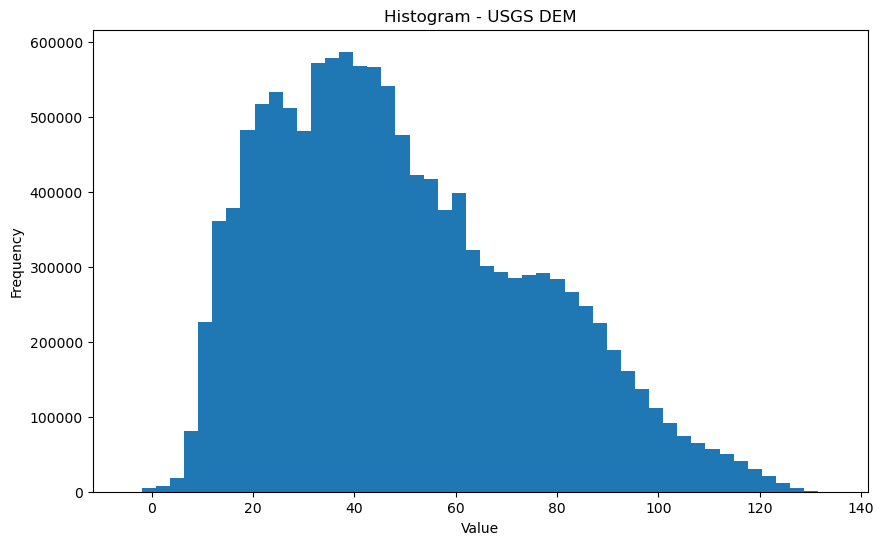

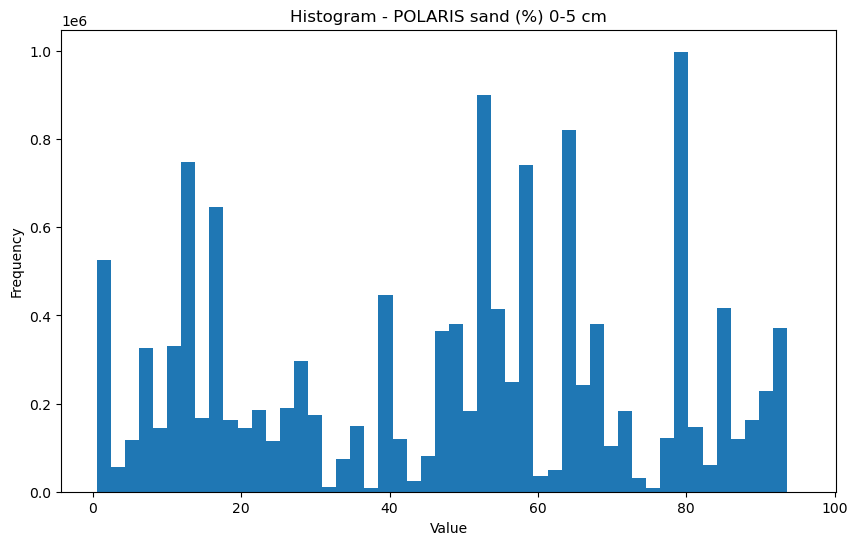

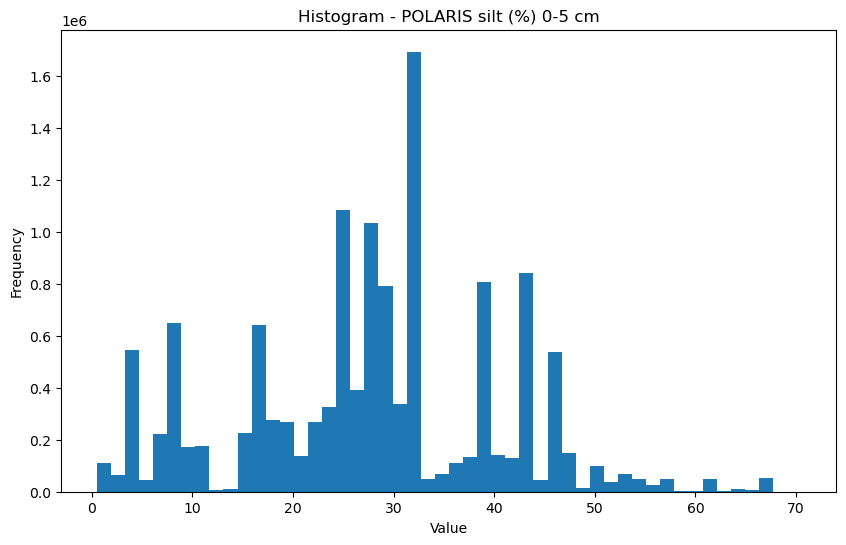

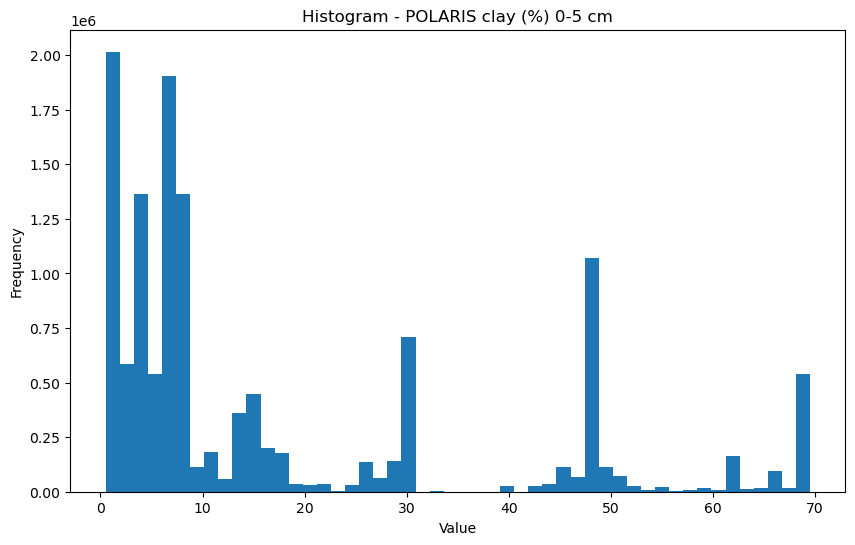

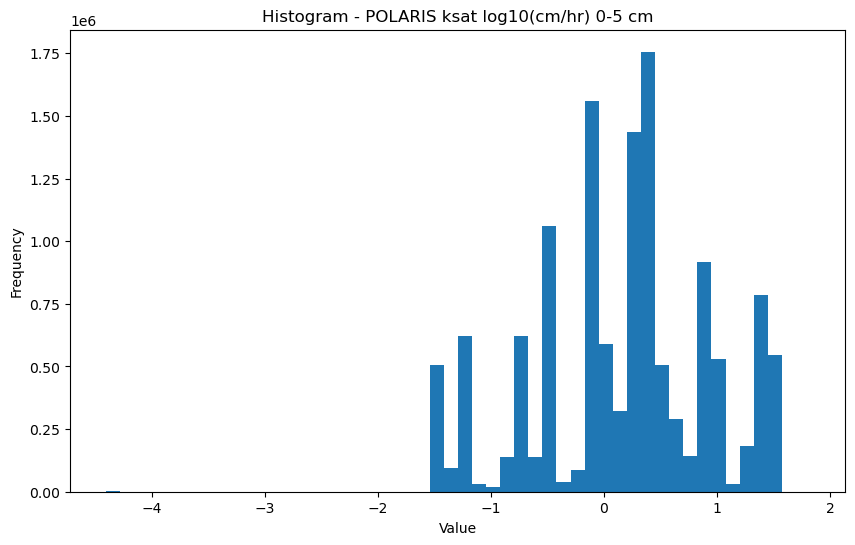

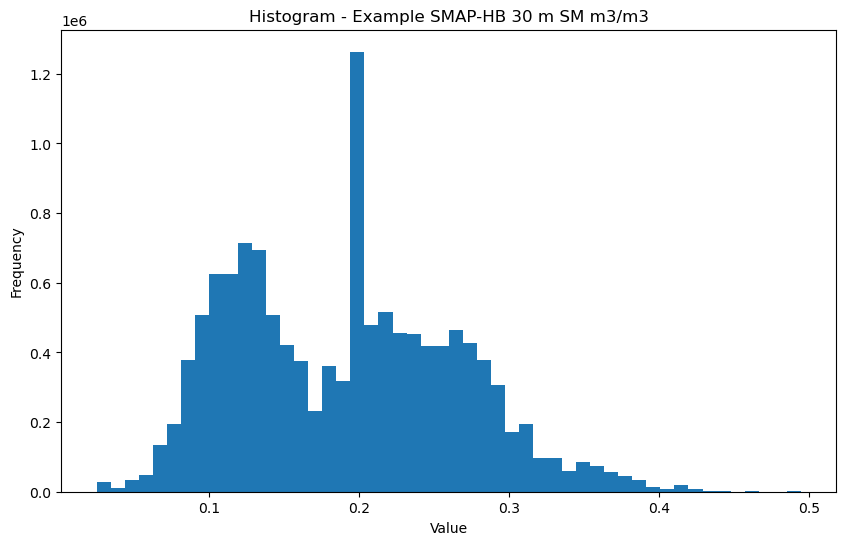

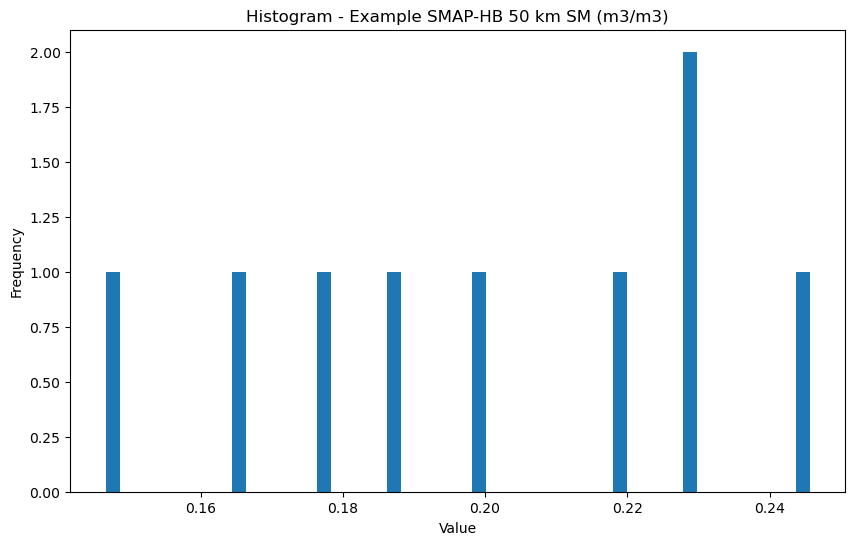

In [5]:
plot_dataarray_histogram(dem_path, "USGS DEM")
plot_dataarray_histogram(polaris_sand_path, "POLARIS sand (%) 0-5 cm")
plot_dataarray_histogram(polaris_silt_path, "POLARIS silt (%) 0-5 cm")
plot_dataarray_histogram(polaris_clay_path, "POLARIS clay (%) 0-5 cm")
plot_dataarray_histogram(polaris_ksat_path, "POLARIS ksat log10(cm/hr) 0-5 cm")

plot_dataarray_histogram(smap_ex_path, "Example SMAP-HB 30 m SM m3/m3")
plot_dataarray_histogram(smap_upscaled_ex_path, "Example SMAP-HB 50 km SM (m3/m3)")


Text(0.5, 1.0, 'Example IMERG 10 km precipitation (mm/day)')

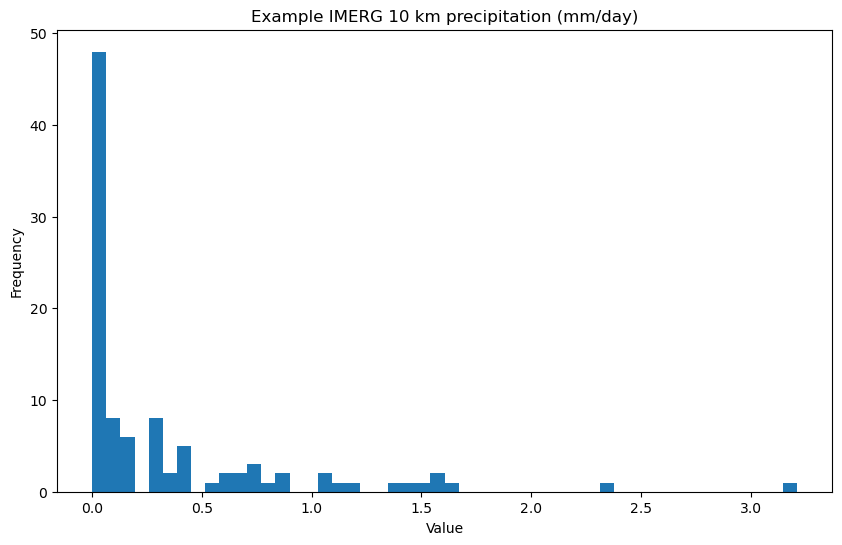

In [6]:
imerg_ex = xr.open_dataset(imerg_ex_path)

imerg_ex_precip = imerg_ex["precipitation"]
plt.figure(figsize=(10, 6))
plt.hist(imerg_ex_precip.values.flatten(), bins=50)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title(f'Example IMERG 10 km precipitation (mm/day)')

In [7]:
# Function to calculate missing data percentage
def calculate_missing_data(dataset, name):
    if isinstance(dataset, xr.Dataset):
        total_pixels = dataset.to_array().size
        missing_pixels = dataset.to_array().isnull().sum().item()
    else:
        total_pixels = dataset.size
        missing_pixels = dataset.isnull().sum().item()
    
    missing_percentage = (missing_pixels / total_pixels) * 100
    return pd.DataFrame({'dataset': [name], 'missing_percentage': [missing_percentage]})


static_missing_data_log = pd.DataFrame(columns=['dataset', 'missing_percentage'])
daily_missing_data_log = pd.DataFrame(columns=['dataset', 'missing_percentage'])

datasets_static = {
    'USGS_DEM': dem_path,
    'NLCD_land_cover': nlcd_path,
    'Polaris_sand_0_5cm': polaris_sand_path,
    'Polaris_silt_0_5cm': polaris_silt_path,
    'Polaris_clay_0_5cm': polaris_clay_path,
    'Polaris_ksat_0_5cm': polaris_ksat_path
}

for name, file in datasets_static.items():
    dataset = xr.open_dataarray(file)  # Use rioxarray to open raster datasets
    static_missing_data_log = pd.concat([static_missing_data_log, calculate_missing_data(dataset, name)], ignore_index=True)

print(static_missing_data_log)


/var/folders/nj/nl4h3gm15nx34s7lxmymmvzr0000gn/T/ipykernel_90879/609656975.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  static_missing_data_log = pd.concat([static_missing_data_log, calculate_missing_data(dataset, name)], ignore_index=True)


              dataset  missing_percentage
0            USGS_DEM            0.000000
1     NLCD_land_cover            0.000000
2  Polaris_sand_0_5cm            0.012739
3  Polaris_silt_0_5cm            0.012739
4  Polaris_clay_0_5cm            0.012739
5  Polaris_ksat_0_5cm            0.012739


In [8]:
# # this will take a really long time to run, so skip for now
# for date_folder in os.listdir(f"{workspace}/data/daily"):
#     date_folder_path = os.path.join(f"{workspace}/data/daily", date_folder)
    
#     if os.path.isdir(date_folder_path):
#         print(f"Processing folder: {date_folder_path}")
        
#         for file_name in os.listdir(date_folder_path):
#             file_path = os.path.join(date_folder_path, file_name)
            
#             if file_name.startswith('SMAP') or file_name.endswith('30m.nc'):
#                 print(f"Processing file: {file_name}")
                
#                 if file_name.endswith('.nc'):
#                     dataset = xr.open_dataset(file_path)
#                 else:
#                     dataset = xr.open_rasterio(file_path)
                
#                 daily_missing_data_log = pd.concat([daily_missing_data_log, calculate_missing_data(dataset, file_name)], ignore_index=True)

# print(daily_missing_data_log)


In [9]:
# Look at just a sample of the daily data first
datasets_daily_sample = {
    'SMAP_HB_30m': smap_ex_path,
    'SMAP_HB_50km': smap_upscaled_ex_path,
    'IMERG_resampled_30m': imerg_resampled_ex_path,
}

for name, file in datasets_daily_sample.items():
    if 'IMERG' in name:
        # For IMERG, open the dataset and select only the precipitation variable
        dataset = xr.open_dataset(file)['precipitation']
    else:
        # For SMAP, open as a DataArray directly
        dataset = xr.open_dataarray(file)
    
    # Calculate missing data and log it
    daily_missing_data_log = pd.concat([daily_missing_data_log, calculate_missing_data(dataset, name)], ignore_index=True)

# Display the missing data log
print(daily_missing_data_log)

/var/folders/nj/nl4h3gm15nx34s7lxmymmvzr0000gn/T/ipykernel_90879/1878052339.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  daily_missing_data_log = pd.concat([daily_missing_data_log, calculate_missing_data(dataset, name)], ignore_index=True)


               dataset  missing_percentage
0          SMAP_HB_30m            1.487361
1         SMAP_HB_50km            0.000000
2  IMERG_resampled_30m            0.000000


The missing data likely come from bodies of water where soil moisture isn't applicable. Let's look at missing data for POLARIS and SMAP 30 m.

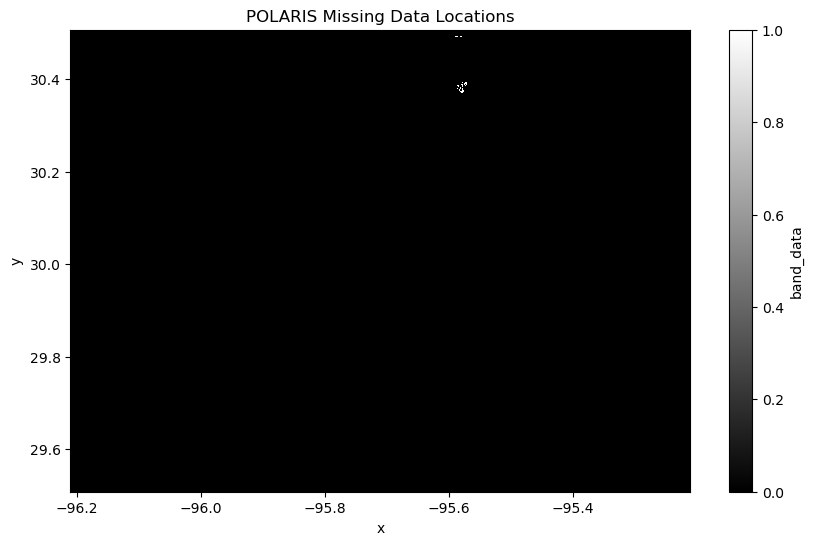

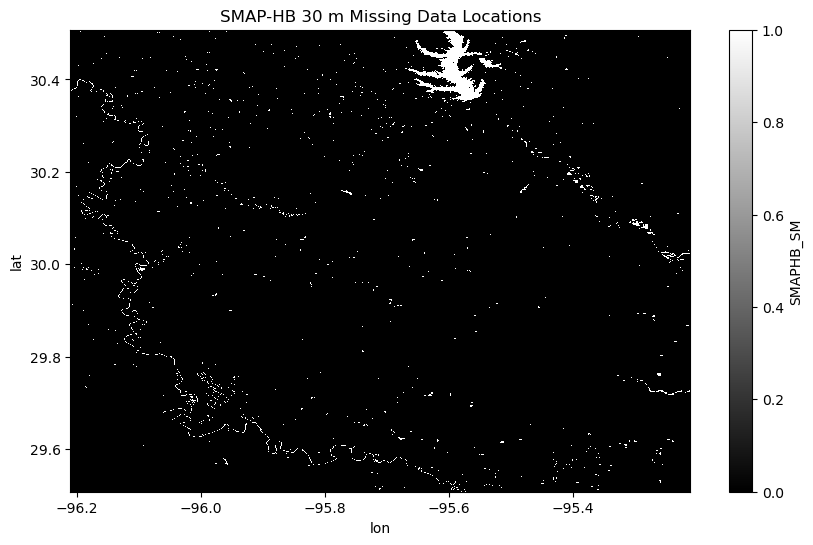

In [10]:
polaris_silt_0_5cm = xr.open_dataarray(polaris_silt_path).isel(band=0)

# Create a mask for missing data (NaN values)
missing_data_mask_polaris = np.isnan(polaris_silt_0_5cm)

fig, ax = plt.subplots(figsize=(10, 6)) 
img_polaris = missing_data_mask_polaris.plot.imshow(ax=ax, cmap='gray') 
plt.title('POLARIS Missing Data Locations')
plt.show()

smap_ex = xr.open_dataarray(smap_ex_path)

missing_data_mask_smap = np.isnan(smap_ex)

fig, ax = plt.subplots(figsize=(10, 6))  
img_smap = missing_data_mask_smap.plot.imshow(ax=ax, cmap='gray') 
plt.title('SMAP-HB 30 m Missing Data Locations')
plt.show()



In [11]:
def calculate_dataset_correlation(data1, data2, method='pearson'):
    """
    Calculate the correlation between two datasets, handling alignment and NaN values.
    
    Parameters:
    data1 (xarray.DataArray): First dataset
    data2 (xarray.DataArray): Second dataset
    method (str): 'pearson' for Pearson correlation or 'spearman' for Spearman correlation
    
    Returns:
    float: Correlation coefficient between the two datasets
    """
    # Align the datasets to ensure they have the same shape and dimensions
    data1_aligned, data2_aligned = xr.align(data1, data2)
    
    # Flatten the arrays and remove NaN values (only valid overlapping data)
    data1_flat = data1_aligned.values.flatten()
    data2_flat = data2_aligned.values.flatten()
    
    # Mask out NaN values
    valid_mask = (~np.isnan(data1_flat)) & (~np.isnan(data2_flat))
    data1_valid = data1_flat[valid_mask]
    data2_valid = data2_flat[valid_mask]
    
    # Calculate correlation based on the specified method
    if method == 'pearson':
        correlation = np.corrcoef(data1_valid, data2_valid)[0, 1]
    elif method == 'spearman':
        correlation, _ = spearmanr(data1_valid, data2_valid)
    else:
        raise ValueError("Invalid method. Choose either 'pearson' or 'spearman'.")
    
    return correlation

In [12]:
polaris_silt = xr.open_dataarray(polaris_silt_path)
dem = xr.open_dataarray(dem_path)
smap_30m = xr.open_dataarray(smap_ex_path)
imerg = xr.open_dataset(imerg_resampled_ex_path)['precipitation']  # Select precipitation variable

# Calculate Pearson correlation between SMAP and DEM
correlation_smap_dem = calculate_dataset_correlation(smap_30m, dem, method='pearson')
print(f"Pearson Correlation (SMAP 30m vs DEM): {correlation_smap_dem}")

# Calculate Spearman correlation between SMAP and IMERG
correlation_smap_imerg = calculate_dataset_correlation(smap_30m, imerg, method='spearman')
print(f"Spearman Correlation (SMAP 30m vs IMERG): {correlation_smap_imerg}")

# Calculate Pearson correlation between Polaris and DEM
correlation_polaris_dem = calculate_dataset_correlation(polaris_silt, dem, method='pearson')
print(f"Pearson Correlation (Polaris Silt vs DEM): {correlation_polaris_dem}")



Pearson Correlation (SMAP 30m vs DEM): -0.05842745042517132
Spearman Correlation (SMAP 30m vs IMERG): -0.015999811243554984


ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:
print(dem.coords['y'])  # Check if y-coordinates are increasing or decreasing
print(polaris_silt.coords['y'])  # Check y-coordinates for POLARIS
print(imerg_resampled_ex_path.coords["y"])

NameError: name 'dem' is not defined